# TD Règles d’association 

Ce répertoire contient les fichiers et solutions pour le TD Règles d'association.  
**Fait par : CHICA Miller et TORRES Jonathan**


## 1. Implémentation de trois méthodes de *Frequent Itemset Generation*

### 1.

In [1]:
from itertools import combinations
from math import ceil
import random
import time

# ===========================================================
#  Fonctions utilitaires
# ===========================================================

def _to_fset(s):
    """Convertit un itérable en frozenset (immuable)."""
    return frozenset(s)

def support_count(itemset, transactions):
    """Nombre de transactions qui contiennent l’itemset."""
    return sum(1 for t in transactions if itemset.issubset(t))

def all_items(transactions):
    """Liste triée de tous les items présents."""
    U = set()
    for t in transactions:
        U |= set(t)
    return sorted(U)

def normalize_minsup(minsup, n_tx):
    """Transforme minsup proportionnel en comptage absolu."""
    return ceil(minsup * n_tx) if minsup < 1 else int(minsup)

# ===========================================================
#  Génération des candidats
# ===========================================================

def generate_candidates_bruteforce(items, k):
    """Toutes les combinaisons de taille k (Brute-force)."""
    return [_to_fset(c) for c in combinations(items, k)]

def generate_candidates_fk1_times_f1(F_prev, F1):
    """Méthode Fk-1 × F1 : ajoute un item de F1 à chaque itemset de Fk-1."""
    C = set()
    for f in F_prev:
        for i in F1:
            if i.issubset(f):
                continue
            cand = f | i
            if len(cand) == len(f) + 1:
                C.add(cand)
    return sorted(C, key=lambda s: tuple(sorted(s)))

def apriori_join(F_prev):
    """Méthode Fk-1 × Fk-1 : join classique d’Apriori (même préfixe)."""
    C = set()
    F_list = sorted([tuple(sorted(f)) for f in F_prev])
    if not F_list:
        return []
    for i in range(len(F_list)):
        for j in range(i + 1, len(F_list)):
            a, b = F_list[i], F_list[j]
            if a[:-1] == b[:-1]:
                C.add(_to_fset(a) | _to_fset(b))
    return sorted(C, key=lambda s: tuple(sorted(s)))

def apriori_prune(Ck, F_prev):
    """Prune : on garde c si tous ses (k-1)-sous-ensembles sont dans F_{k-1}."""
    F_prev_set = set(F_prev)
    kept, pruned = [], []
    for c in Ck:
        k = len(c)
        ok = all(_to_fset(s) in F_prev_set for s in combinations(c, k - 1))
        (kept if ok else pruned).append(c)
    return kept, pruned

# ===========================================================
#  Point 1 : génération des itemsets fréquents
# ===========================================================

def frequent_itemset_generation(transactions, minsup, method="Fk-1 x Fk-1", verbose=False):
    """
    Génère les itemsets fréquents selon :
      - "Brute-force"
      - "Fk-1 x F1"
      - "Fk-1 x Fk-1"
    Affiche (si verbose) : F (fréquent), I (infréquent), N (pruné).
    """
    # Normalisation du nom de méthode
    norm = method.lower().replace(' ', '').replace('-', '').replace('×', 'x')
    if norm == "bruteforce":
        method_key = "bruteforce"
    elif norm == "fk1xf1":
        method_key = "fk1xf1"
    elif norm == "fk1xfk1":
        method_key = "fk1xfk1"
    else:
        raise ValueError("Méthode invalide : 'Brute-force', 'Fk-1 x F1' ou 'Fk-1 x Fk-1'.")

    # Préparation
    T = [set(t) for t in transactions]
    n_tx = len(T)
    minsup_count = normalize_minsup(minsup, n_tx)
    U = all_items(T)

    # F1
    if verbose:
        print(f"Transactions = {n_tx}")
        print(f"minsup (count) = {minsup_count}\n1-itemsets")
    F, F1 = {}, []
    for i in U:
        X = _to_fset([i])
        cnt = support_count(X, T)
        if cnt >= minsup_count:
            F1.append(X)
            if verbose:
                print(f"{i} {cnt} F")
        else:
            if verbose:
                print(f"{i} {cnt} I")
    F[1] = sorted(F1, key=lambda s: tuple(sorted(s)))

    # k >= 2
    k = 2
    while F.get(k - 1):
        if verbose:
            print("=" * 25)
            print(f"{k}-itemsets")

        # Candidats
        if method_key == "bruteforce":
            Ck = generate_candidates_bruteforce(U, k)
            Ck_kept, Ck_pruned = apriori_prune(Ck, F[k - 1])
        elif method_key == "fk1xf1":
            Ck = generate_candidates_fk1_times_f1(F[k - 1], F[1])
            Ck_kept, Ck_pruned = apriori_prune(Ck, F[k - 1])
        else:  # fk1xfk1
            Ck = apriori_join(F[k - 1])
            Ck_kept, Ck_pruned = apriori_prune(Ck, F[k - 1])

        # Affichage des prunés
        if verbose:
            for c in Ck_pruned:
                print(f"{','.join(sorted(c))} N")

        # Comptage du support
        Fk = []
        for c in Ck_kept:
            cnt = support_count(c, T)
            if cnt >= minsup_count:
                Fk.append(c)
                if verbose:
                    print(f"{','.join(sorted(c))} {cnt} F")
            else:
                if verbose:
                    print(f"{','.join(sorted(c))} {cnt} I")

        if not Fk:
            break
        F[k] = sorted(Fk, key=lambda s: tuple(sorted(s)))
        k += 1

    return F

# ===========================================================
#  Point 2 : génération de données + benchmark
# ===========================================================

def gen_transactions(n_tx, n_items, w_min, w_max, seed=42):
    """Génère un jeu de transactions synthétiques (aléatoire)."""
    rng = random.Random(seed)
    items = [f"p{i}" for i in range(n_items)]
    Tx = []
    for _ in range(n_tx):
        w = rng.randint(w_min, w_max)
        Tx.append(rng.sample(items, k=min(w, n_items)))
    return Tx

def benchmark_metodos(
    transactions_list,
    minsup,
    methods=("Brute-force", "Fk-1 x F1", "Fk-1 x Fk-1"),
    runs=3,
    plot=False
):
    """
    Mesure le temps moyen (s) par méthode sur plusieurs datasets.
    Retourne {méthode : [temps_moyens]} ; peut tracer une courbe (plot=True).
    """
    series = {m: [] for m in methods}
    for Tx in transactions_list:
        for m in methods:
            acc = 0.0
            for _ in range(runs):
                t0 = time.time()
                frequent_itemset_generation(Tx, minsup, method=m, verbose=False)
                acc += (time.time() - t0)
            series[m].append(acc / runs)

    if plot:
        import matplotlib.pyplot as plt
        for m in methods:
            plt.plot(range(1, len(transactions_list) + 1), series[m], marker="o", label=m)
        plt.xlabel("Dataset (index)")
        plt.ylabel("Temps (s)")
        plt.title("Benchmark des méthodes de génération de candidats")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return series


### 2.

In [2]:
transactions = [
    ["Bread","Milk"],
    ["Bread","Diapers","Beer","Eggs"],
    ["Milk","Diapers","Beer","Coke"],
    ["Bread","Milk","Diapers","Beer"],
    ["Bread","Milk","Diapers","Coke"]
]

print("=== Méthode : Brute-force ===")
frequent_itemset_generation(transactions, minsup=0.6, method="Brute-force", verbose=True)

=== Méthode : Brute-force ===
Transactions = 5
minsup (count) = 3
1-itemsets
Beer 3 F
Bread 4 F
Coke 2 I
Diapers 4 F
Eggs 1 I
Milk 4 F
2-itemsets
Beer,Coke N
Beer,Eggs N
Bread,Coke N
Bread,Eggs N
Coke,Diapers N
Coke,Eggs N
Coke,Milk N
Diapers,Eggs N
Eggs,Milk N
Beer,Bread 2 I
Beer,Diapers 3 F
Beer,Milk 2 I
Bread,Diapers 3 F
Bread,Milk 3 F
Diapers,Milk 3 F
3-itemsets
Beer,Bread,Coke N
Beer,Bread,Diapers N
Beer,Bread,Eggs N
Beer,Bread,Milk N
Beer,Coke,Diapers N
Beer,Coke,Eggs N
Beer,Coke,Milk N
Beer,Diapers,Eggs N
Beer,Diapers,Milk N
Beer,Eggs,Milk N
Bread,Coke,Diapers N
Bread,Coke,Eggs N
Bread,Coke,Milk N
Bread,Diapers,Eggs N
Bread,Eggs,Milk N
Coke,Diapers,Eggs N
Coke,Diapers,Milk N
Coke,Eggs,Milk N
Diapers,Eggs,Milk N
Bread,Diapers,Milk 2 I


{1: [frozenset({'Beer'}),
  frozenset({'Bread'}),
  frozenset({'Diapers'}),
  frozenset({'Milk'})],
 2: [frozenset({'Beer', 'Diapers'}),
  frozenset({'Bread', 'Diapers'}),
  frozenset({'Bread', 'Milk'}),
  frozenset({'Diapers', 'Milk'})]}

In [3]:
print("=== Méthode : Fk-1 x F1 ===")
frequent_itemset_generation(transactions, minsup=0.6, method="Fk-1 x F1", verbose=True)

=== Méthode : Fk-1 x F1 ===
Transactions = 5
minsup (count) = 3
1-itemsets
Beer 3 F
Bread 4 F
Coke 2 I
Diapers 4 F
Eggs 1 I
Milk 4 F
2-itemsets
Beer,Bread 2 I
Beer,Diapers 3 F
Beer,Milk 2 I
Bread,Diapers 3 F
Bread,Milk 3 F
Diapers,Milk 3 F
3-itemsets
Beer,Bread,Diapers N
Beer,Bread,Milk N
Beer,Diapers,Milk N
Bread,Diapers,Milk 2 I


{1: [frozenset({'Beer'}),
  frozenset({'Bread'}),
  frozenset({'Diapers'}),
  frozenset({'Milk'})],
 2: [frozenset({'Beer', 'Diapers'}),
  frozenset({'Bread', 'Diapers'}),
  frozenset({'Bread', 'Milk'}),
  frozenset({'Diapers', 'Milk'})]}

In [4]:
print("=== Méthode : Fk-1 x Fk-1 ===")
frequent_itemset_generation(transactions, minsup=0.6, method="Fk-1 x Fk-1", verbose=True)

=== Méthode : Fk-1 x Fk-1 ===
Transactions = 5
minsup (count) = 3
1-itemsets
Beer 3 F
Bread 4 F
Coke 2 I
Diapers 4 F
Eggs 1 I
Milk 4 F
2-itemsets
Beer,Bread 2 I
Beer,Diapers 3 F
Beer,Milk 2 I
Bread,Diapers 3 F
Bread,Milk 3 F
Diapers,Milk 3 F
3-itemsets
Bread,Diapers,Milk 2 I


{1: [frozenset({'Beer'}),
  frozenset({'Bread'}),
  frozenset({'Diapers'}),
  frozenset({'Milk'})],
 2: [frozenset({'Beer', 'Diapers'}),
  frozenset({'Bread', 'Diapers'}),
  frozenset({'Bread', 'Milk'}),
  frozenset({'Diapers', 'Milk'})]}

### 3.

In [5]:
# ---------- Jeu (a) : minsup = 0.3 ----------
# Transactions fournies par l'énoncé
Tx_a = [
    ["a","b","d","e"], ["b","c","d"], ["a","b","d","e"], ["a","c","d","e"],
    ["b","c","d","e"], ["b","c","d","e"], ["b","d","e"], ["c","d"],
    ["a","b","c"], ["a","d","e"], ["b","d"]
]
minsup_a = 0.3  # seuil de support (proportion)

# Petite fonction utilitaire pour lancer une méthode et afficher résumé
def run_and_show_fr(label, tx, minsup, method):
    """
    Lance frequent_itemset_generation avec 'method' et affiche :
      - sortie verbose (F/I/N)
      - résumé des F_k trouvés
    """
    print(f"\n=== {label} | méthode : {method} ===")
    F = frequent_itemset_generation(tx, minsup=minsup, method=method, verbose=True)
    print("\nRésumé — itemsets fréquents par taille :")
    for k in sorted(F.keys()):
        print(f"F{k} = {[sorted(list(s)) for s in F[k]]}")
    return F

# Exécution pour les 3 méthodes (ordre demandé)
F_a_bruteforce = run_and_show_fr("Jeu (a)", Tx_a, minsup_a, "Brute-force")
F_a_fk1xf1      = run_and_show_fr("Jeu (a)", Tx_a, minsup_a, "Fk-1 x F1")
F_a_fk1xfk1     = run_and_show_fr("Jeu (a)", Tx_a, minsup_a, "Fk-1 x Fk-1")

# Afficher minsup en comptage absolu (utile pour le rapport)
count_a = __import__('math').ceil(minsup_a * len(Tx_a))
print(f"\nminsup (proportion) = {minsup_a}  → minsup (count) = {count_a} / {len(Tx_a)}")



=== Jeu (a) | méthode : Brute-force ===
Transactions = 11
minsup (count) = 4
1-itemsets
a 5 F
b 8 F
c 6 F
d 10 F
e 7 F
2-itemsets
a,b 3 I
a,c 2 I
a,d 4 F
a,e 4 F
b,c 4 F
b,d 7 F
b,e 5 F
c,d 5 F
c,e 3 I
d,e 7 F
3-itemsets
a,b,c N
a,b,d N
a,b,e N
a,c,d N
a,c,e N
b,c,e N
c,d,e N
a,d,e 4 F
b,c,d 3 I
b,d,e 5 F
4-itemsets
a,b,c,d N
a,b,c,e N
a,b,d,e N
a,c,d,e N
b,c,d,e N

Résumé — itemsets fréquents par taille :
F1 = [['a'], ['b'], ['c'], ['d'], ['e']]
F2 = [['a', 'd'], ['a', 'e'], ['b', 'c'], ['b', 'd'], ['b', 'e'], ['c', 'd'], ['d', 'e']]
F3 = [['a', 'd', 'e'], ['b', 'd', 'e']]

=== Jeu (a) | méthode : Fk-1 x F1 ===
Transactions = 11
minsup (count) = 4
1-itemsets
a 5 F
b 8 F
c 6 F
d 10 F
e 7 F
2-itemsets
a,b 3 I
a,c 2 I
a,d 4 F
a,e 4 F
b,c 4 F
b,d 7 F
b,e 5 F
c,d 5 F
c,e 3 I
d,e 7 F
3-itemsets
a,b,c N
a,b,d N
a,b,e N
a,c,d N
a,c,e N
b,c,e N
c,d,e N
a,d,e 4 F
b,c,d 3 I
b,d,e 5 F
4-itemsets
a,b,d,e N
a,c,d,e N
b,c,d,e N

Résumé — itemsets fréquents par taille :
F1 = [['a'], ['b'], ['c'], ['

In [6]:
# ---------- Jeu (b) : minsup = 0.5 ----------
Tx_b = [
    ["b","c","d"], ["a","b","c","d","e"], ["a","b","c","e"],
    ["a","b","d","e"], ["b","c","e"], ["a","b","d","e"]
]
minsup_b = 0.5

def run_and_show_fr(label, tx, minsup, method):
    """
    Comme précédemment : exécute la génération et affiche résumé.
    """
    print(f"\n=== {label} | méthode : {method} ===")
    F = frequent_itemset_generation(tx, minsup=minsup, method=method, verbose=True)
    print("\nRésumé — itemsets fréquents par taille :")
    for k in sorted(F.keys()):
        print(f"F{k} = {[sorted(list(s)) for s in F[k]]}")
    return F

# Exécution pour les 3 méthodes
F_b_bruteforce = run_and_show_fr("Jeu (b)", Tx_b, minsup_b, "Brute-force")
F_b_fk1xf1      = run_and_show_fr("Jeu (b)", Tx_b, minsup_b, "Fk-1 x F1")
F_b_fk1xfk1     = run_and_show_fr("Jeu (b)", Tx_b, minsup_b, "Fk-1 x Fk-1")

# minsup absolu pour le rapport
count_b = __import__('math').ceil(minsup_b * len(Tx_b))
print(f"\nminsup (proportion) = {minsup_b}  → minsup (count) = {count_b} / {len(Tx_b)}")



=== Jeu (b) | méthode : Brute-force ===
Transactions = 6
minsup (count) = 3
1-itemsets
a 4 F
b 6 F
c 4 F
d 4 F
e 5 F
2-itemsets
a,b 4 F
a,c 2 I
a,d 3 F
a,e 4 F
b,c 4 F
b,d 4 F
b,e 5 F
c,d 2 I
c,e 3 F
d,e 3 F
3-itemsets
a,b,c N
a,c,d N
a,c,e N
b,c,d N
c,d,e N
a,b,d 3 F
a,b,e 4 F
a,d,e 3 F
b,c,e 3 F
b,d,e 3 F
4-itemsets
a,b,c,d N
a,b,c,e N
a,c,d,e N
b,c,d,e N
a,b,d,e 3 F
5-itemsets
a,b,c,d,e N

Résumé — itemsets fréquents par taille :
F1 = [['a'], ['b'], ['c'], ['d'], ['e']]
F2 = [['a', 'b'], ['a', 'd'], ['a', 'e'], ['b', 'c'], ['b', 'd'], ['b', 'e'], ['c', 'e'], ['d', 'e']]
F3 = [['a', 'b', 'd'], ['a', 'b', 'e'], ['a', 'd', 'e'], ['b', 'c', 'e'], ['b', 'd', 'e']]
F4 = [['a', 'b', 'd', 'e']]

=== Jeu (b) | méthode : Fk-1 x F1 ===
Transactions = 6
minsup (count) = 3
1-itemsets
a 4 F
b 6 F
c 4 F
d 4 F
e 5 F
2-itemsets
a,b 4 F
a,c 2 I
a,d 3 F
a,e 4 F
b,c 4 F
b,d 4 F
b,e 5 F
c,d 2 I
c,e 3 F
d,e 3 F
3-itemsets
a,b,c N
a,c,d N
a,c,e N
b,c,d N
c,d,e N
a,b,d 3 F
a,b,e 4 F
a,d,e 3 F
b,c,e 3 F
b,

---

## 2. Comparaison des implémentations de Section 1

### 1.

In [7]:
import random

def generate_transactions(n_transactions=1000, n_items=50, width_range=(5, 20)):
    items = [f"p{i}" for i in range(n_items)]
    transactions = []
    for _ in range(n_transactions):
        width = random.randint(*width_range)
        transaction = random.sample(items, width)
        transactions.append(transaction)
    return transactions

transactions = generate_transactions(10, 8, (2, 5))
for t in transactions:
    print(t)


['p0', 'p1', 'p3', 'p6']
['p7', 'p1', 'p3']
['p2', 'p6', 'p1', 'p7', 'p3']
['p7', 'p4', 'p2']
['p5', 'p6']
['p0', 'p1', 'p6', 'p3', 'p2']
['p7', 'p2', 'p0', 'p6']
['p7', 'p6', 'p2']
['p6', 'p7', 'p5']
['p3', 'p4', 'p0', 'p1']


### 2.

In [8]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


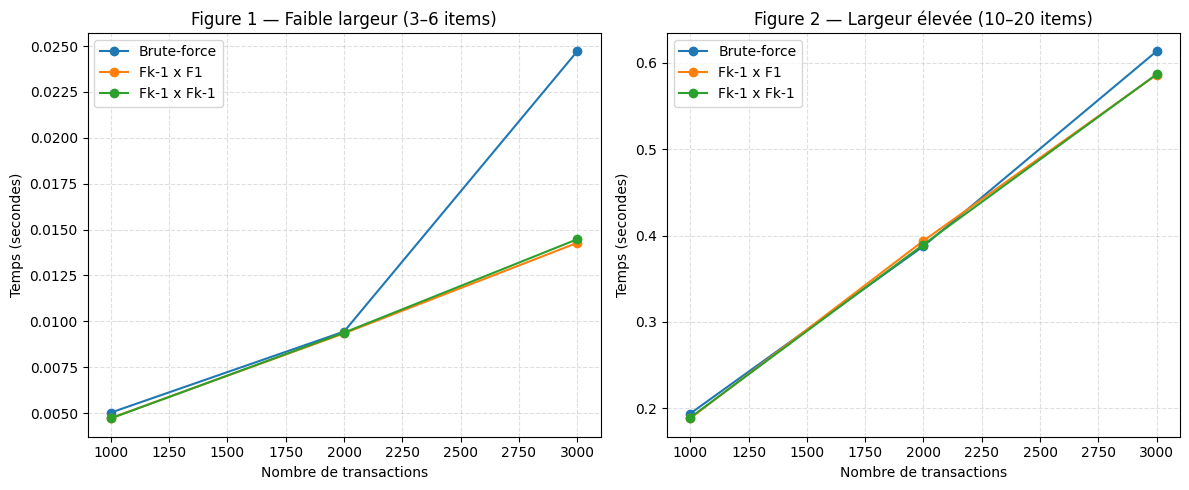

In [9]:
import matplotlib.pyplot as plt

# ---------- Configuration de la figure ----------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 ligne, 2 colonnes

# ==========================================================
#  Figure 1 — Faible largeur (3–6 items)
# ==========================================================
n_items   = 40
w_min, w_max = 3, 6
minsup    = 0.20
n_list    = [1000, 2000, 3000]

Tx_list = [gen_transactions(n_tx=n, n_items=n_items, w_min=w_min, w_max=w_max, seed=42)
           for n in n_list]

series1 = benchmark_metodos(Tx_list, minsup=minsup, runs=5,
                            methods=("Brute-force","Fk-1 x F1","Fk-1 x Fk-1"),
                            plot=False)

for m, times in series1.items():
    axes[0].plot(n_list, times, marker="o", label=m)

axes[0].set_xlabel("Nombre de transactions")
axes[0].set_ylabel("Temps (secondes)")
axes[0].set_title("Figure 1 — Faible largeur (3–6 items)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.4)

# ==========================================================
#  Figure 2 — Largeur élevée (10–20 items)
# ==========================================================
n_items   = 60
w_min, w_max = 10, 20
minsup    = 0.15
n_list    = [1000, 2000, 3000]

Tx_list = [gen_transactions(n_tx=n, n_items=n_items, w_min=w_min, w_max=w_max, seed=24)
           for n in n_list]

series2 = benchmark_metodos(Tx_list, minsup=minsup, runs=5,
                            methods=("Brute-force","Fk-1 x F1","Fk-1 x Fk-1"),
                            plot=False)

for m, times in series2.items():
    axes[1].plot(n_list, times, marker="o", label=m)

axes[1].set_xlabel("Nombre de transactions")
axes[1].set_ylabel("Temps (secondes)")
axes[1].set_title("Figure 2 — Largeur élevée (10–20 items)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.4)

# ==========================================================
#  Ajustement et affichage final
# ==========================================================
plt.tight_layout()
plt.show()


---

## 3. Comparaison avec les implémentations de *MLxtend* et *Spark MLlib*

### 1.

In [10]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.preprocessing import TransactionEncoder

transactions = [
    ["Bread", "Milk"],
    ["Bread", "Diapers", "Beer", "Eggs"],
    ["Milk", "Diapers", "Beer", "Coke"],
    ["Bread", "Milk", "Diapers", "Beer"],
    ["Bread", "Milk", "Diapers", "Coke"]
]

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

# Apriori avec minsup = 0.6
frequent_itemsets = apriori(df, min_support=0.6, use_colnames=True)
print(frequent_itemsets)


   support          itemsets
0      0.6            (Beer)
1      0.8           (Bread)
2      0.8         (Diapers)
3      0.8            (Milk)
4      0.6   (Beer, Diapers)
5      0.6  (Bread, Diapers)
6      0.6     (Bread, Milk)
7      0.6   (Diapers, Milk)


### 2.

In [11]:
# spark_fp_growth_bread_milk.py
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

spark = SparkSession.builder.appName("FP-Growth-BreadMilk").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

data = [
    (0, ["Bread", "Milk"]),
    (1, ["Bread", "Diapers", "Beer", "Eggs"]),
    (2, ["Milk", "Diapers", "Beer", "Coke"]),
    (3, ["Bread", "Milk", "Diapers", "Beer"]),
    (4, ["Bread", "Milk", "Diapers", "Coke"]),
]
df = spark.createDataFrame(data, ["tid", "items"])

fp = FPGrowth(itemsCol="items", minSupport=0.6, minConfidence=0.6)
model = fp.fit(df)

print("\n=== Frequent itemsets (items | freq) ===")
(model.freqItemsets
     .orderBy(pyspark.sql.functions.size("items").asc(), "items")
     .show(truncate=False))

spark.stop()


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/19 10:50:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



=== Frequent itemsets (items | freq) ===
+----------------+----+
|items           |freq|
+----------------+----+
|[Beer]          |3   |
|[Bread]         |4   |
|[Diapers]       |4   |
|[Milk]          |4   |
|[Beer, Diapers] |3   |
|[Diapers, Bread]|3   |
|[Diapers, Milk] |3   |
|[Milk, Bread]   |3   |
+----------------+----+



Les résultats obtenus avec MLxtend et Spark sont équivalents à ceux de notre implémentation, car tous appliquent le même principe : trouver les itemsets dont le support est ≥ minsup.
Même si Apriori (notre code et MLxtend) et FP-Growth (Spark) utilisent des algorithmes différents, ils analysent les mêmes transactions et calculent le même support.
Les petites variations d’ordre ou d’affichage ne changent rien : les itemsets fréquents sont exactement les mêmes.

### 3.

In [12]:
import time
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

def run_mlxtend(transactions, minsup):
    te = TransactionEncoder()
    te_ary = te.fit(transactions).transform(transactions)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    start = time.time()
    apriori(df, min_support=minsup, use_colnames=True)
    return time.time() - start


In [13]:
from pyspark.sql import SparkSession
from pyspark.ml.fpm import FPGrowth

def run_spark(transactions, minsup):
    spark = SparkSession.builder.master("local[*]").appName("Benchmark").getOrCreate()
    spark.sparkContext.setLogLevel("ERROR")

    data = [(i, t) for i, t in enumerate(transactions)]
    df = spark.createDataFrame(data, ["tid", "items"])

    fp = FPGrowth(itemsCol="items", minSupport=minsup, minConfidence=0.5)

    start = time.time()
    model = fp.fit(df)
    elapsed = time.time() - start

    spark.stop()
    return elapsed


In [14]:
def benchmark_mlxtend_spark(Tx_list, minsup=0.2, runs=3):
    times_mlxtend = []
    times_spark = []

    for tx in Tx_list:
        # MLxtend
        t = 0
        for _ in range(runs):
            t += run_mlxtend(tx, minsup)
        times_mlxtend.append(t / runs)

        # Spark
        t = 0
        for _ in range(runs):
            t += run_spark(tx, minsup)
        times_spark.append(t / runs)

    return {
        "MLxtend": times_mlxtend,
        "Spark MLlib": times_spark,
    }


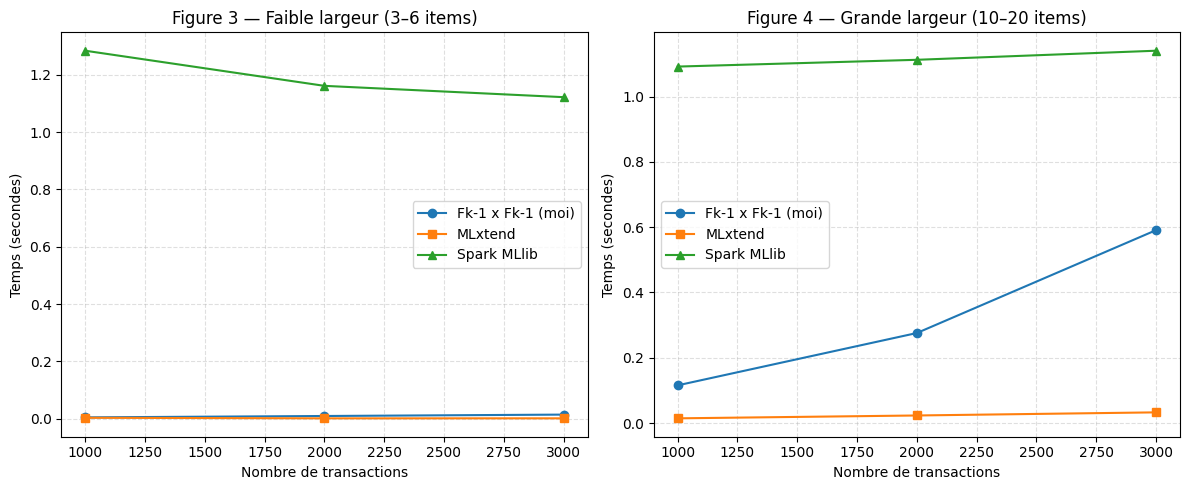

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ======================================
# Figure 3 — Faible largeur (3–6 items)
# ======================================
n_items = 40
w_min, w_max = 3, 6
minsup = 0.20
n_list = [1000, 2000, 3000]

Tx_list = [gen_transactions(n_tx=n, n_items=n_items,
                            w_min=w_min, w_max=w_max, seed=10)
           for n in n_list]

#  (Fk-1 × Fk-1)
series_my = benchmark_metodos(Tx_list, minsup=minsup, runs=3,
                              methods=("Fk-1 x Fk-1",),
                              plot=False)["Fk-1 x Fk-1"]

# MLxtend + Spark
series_ext = benchmark_mlxtend_spark(Tx_list, minsup=minsup, runs=3)

axes[0].plot(n_list, series_my, marker="o", label="Fk-1 x Fk-1 (moi)")
axes[0].plot(n_list, series_ext["MLxtend"], marker="s", label="MLxtend")
axes[0].plot(n_list, series_ext["Spark MLlib"], marker="^", label="Spark MLlib")

axes[0].set_title("Figure 3 — Faible largeur (3–6 items)")
axes[0].set_xlabel("Nombre de transactions")
axes[0].set_ylabel("Temps (secondes)")
axes[0].grid(True, linestyle="--", alpha=0.4)
axes[0].legend()

# ======================================
# Figure 4 — Grande largeur (10–20 items)
# ======================================
n_items = 60
w_min, w_max = 10, 20
minsup = 0.15
n_list = [1000, 2000, 3000]

Tx_list = [gen_transactions(n_tx=n, n_items=n_items,
                            w_min=w_min, w_max=w_max, seed=20)
           for n in n_list]

# Notre méthode
series_my = benchmark_metodos(Tx_list, minsup=minsup, runs=3,
                              methods=("Fk-1 x Fk-1",),
                              plot=False)["Fk-1 x Fk-1"]

# MLxtend + Spark
series_ext = benchmark_mlxtend_spark(Tx_list, minsup=minsup, runs=3)

axes[1].plot(n_list, series_my, marker="o", label="Fk-1 x Fk-1 (moi)")
axes[1].plot(n_list, series_ext["MLxtend"], marker="s", label="MLxtend")
axes[1].plot(n_list, series_ext["Spark MLlib"], marker="^", label="Spark MLlib")

axes[1].set_title("Figure 4 — Grande largeur (10–20 items)")
axes[1].set_xlabel("Nombre de transactions")
axes[1].set_ylabel("Temps (secondes)")
axes[1].grid(True, linestyle="--", alpha=0.4)
axes[1].legend()

plt.tight_layout()
plt.show()


Dans nos expériences, MLxtend est généralement la plus rapide, car il s’agit d’une implémentation optimisée d’Apriori en Python sur une seule machine.
Notre propre implémentation Fk-1 × Fk-1 est un peu plus lente mais suit la même tendance.
Spark MLlib (FP-Growth) est en général plus lent sur ces petits jeux de données, car le coût de démarrer Spark et de gérer l’infrastructure distribuée domine le temps de calcul.
En revanche, sur des jeux de données beaucoup plus volumineux ou réellement distribués, l’architecture de Spark devient plus avantageuse que les implémentations centralisées.

---